In [1]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"
import albumentations as albu
import segmentation_models as sm
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
import cv2
from model import ModelCreator
from datapipeline import DatasetCreator
import random
import shutil
tf.random.set_seed(1)
random.seed(1)

Segmentation Models: using `tf.keras` framework.


In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [3]:
height = 512

In [4]:
val_transforms = albu.Compose([
    albu.Resize(height, height),
    albu.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [5]:
valdataset = DatasetCreator(val_transforms)

In [6]:
valdata = valdataset('crosval/val/*png','castom-masks/masks_machine/')
len(valdata)

8

In [7]:
trainaugmentation = albu.Compose([
    albu.Resize(height*2,height*2),
    albu.RandomCrop(height, height,always_apply=True),
    albu.HorizontalFlip(p=0.5),
    albu.VerticalFlip(p=0.5),
    albu.RandomRotate90(p=0.5),
    albu.Transpose(p=0.5),
    albu.ShiftScaleRotate(shift_limit=0.01, scale_limit=0.04, rotate_limit=15, p=0.5),
    albu.ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03, p=0.5),
    albu.GridDistortion(p=0.5),
    albu.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
    albu.RandomBrightnessContrast(p=0.5),
    albu.RandomGamma(p=0.5),
    albu.GaussianBlur(blur_limit=(3, 7), p=0.5),
    albu.GaussNoise(),
    albu.CLAHE(clip_limit=4.0, tile_grid_size=(8, 8), always_apply=False, p=0.5), 
    albu.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225],always_apply=True)
])#todo change later

In [8]:
traindataset = DatasetCreator(trainaugmentation)

In [9]:
traindata = traindataset('crosval/train/*png','castom-masks/masks_machine/')
len(traindata)

24

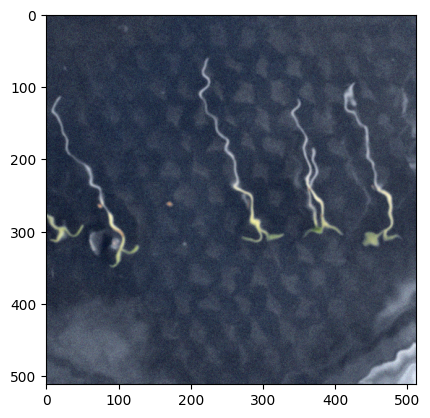

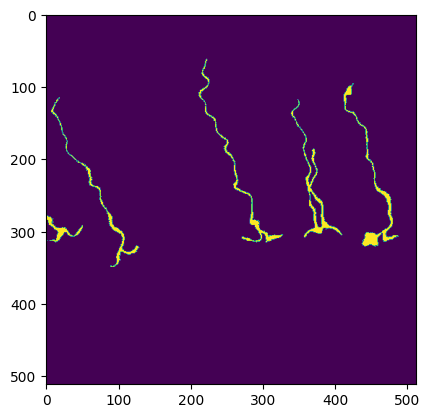

In [10]:
for image,mask in traindata.take(1):
        plt.imshow(tf.keras.utils.array_to_img(image[0]))
        plt.pause(1)
        plt.imshow(tf.keras.utils.array_to_img(mask[0]))

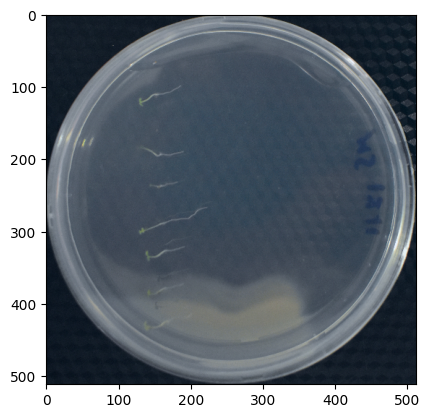

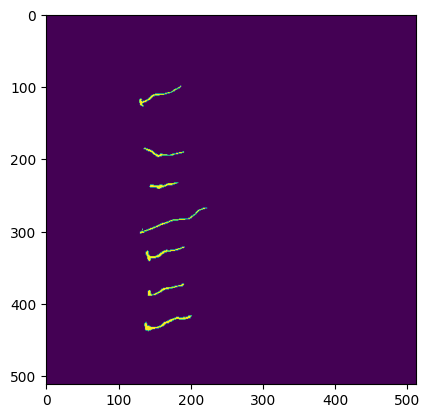

In [11]:
for image,mask in valdata.take(1):
        plt.imshow(tf.keras.utils.array_to_img(image[0]))
        plt.pause(1)
        plt.imshow(tf.keras.utils.array_to_img(mask[0]))

In [12]:
modelcreator = ModelCreator()
model = modelcreator.buildmodel()
model.compile('Adam', loss=sm.losses.binary_focal_dice_loss, metrics=[sm.metrics.iou_score])

KerasTensor(type_spec=TensorSpec(shape=(None, 512, 512, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")
KerasTensor(type_spec=TensorSpec(shape=(None, 512, 512, 1), dtype=tf.float32, name=None), name='conv2d_transpose_5/Sigmoid:0', description="created by layer 'conv2d_transpose_5'")


In [13]:
model.save('testovik.h5')

/opt/homebrew/Caskroom/miniconda/base/envs/tf/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [14]:
#tf.keras.utils.plot_model(model)

In [15]:
def scheduler(epoch, lr):
    return lr * tf.math.exp(-0.1) if epoch > 15 and epoch % 15 == 0 else lr

callback =[
    tf.keras.callbacks.EarlyStopping(min_delta=0.0001,patience=30,verbose=1),
    tf.keras.callbacks.LearningRateScheduler(scheduler,verbose=1),
    tf.keras.callbacks.ModelCheckpoint(filepath='bestmodel/',save_best_only=True,monitor='val_loss',verbose=1)
]

In [16]:
# fit model
model_history = model.fit(
    traindata,
    epochs=1000,
    validation_data=valdata,
    callbacks=callback,
    )


Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/60


24/24 [==============================] - ETA: 0s - loss: 2.1627 - iou_score: 0.0292
Epoch 1: val_loss improved from inf to 8.36425, saving model to bestmodel/
INFO:tensorflow:Assets written to: bestmodel/assets


INFO:tensorflow:Assets written to: bestmodel/assets


24/24 [==============================] - 38s 1s/step - loss: 2.1627 - iou_score: 0.0292 - val_loss: 8.3643 - val_iou_score: 0.0163 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/60
24/24 [==============================] - ETA: 0s - loss: 1.3160 - iou_score: 0.0238
Epoch 2: val_loss improved from 8.36425 to 6.34405, saving model to bestmodel/
INFO:tensorflow:Assets written to: bestmodel/assets


INFO:tensorflow:Assets written to: bestmodel/assets


24/24 [==============================] - 36s 1s/step - loss: 1.3160 - iou_score: 0.0238 - val_loss: 6.3441 - val_iou_score: 0.0154 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/60
24/24 [==============================] - ETA: 0s - loss: 1.1711 - iou_score: 0.0348
Epoch 3: val_loss improved from 6.34405 to 4.99416, saving model to bestmodel/
INFO:tensorflow:Assets written to: bestmodel/assets


INFO:tensorflow:Assets written to: bestmodel/assets


24/24 [==============================] - 37s 1s/step - loss: 1.1711 - iou_score: 0.0348 - val_loss: 4.9942 - val_iou_score: 0.0171 - lr: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/60
24/24 [==============================] - ETA: 0s - loss: 1.0246 - iou_score: 0.0563
Epoch 4: val_loss improved from 4.99416 to 1.18218, saving model to bestmodel/
INFO:tensorflow:Assets written to: bestmodel/assets


INFO:tensorflow:Assets written to: bestmodel/assets


24/24 [==============================] - 37s 1s/step - loss: 1.0246 - iou_score: 0.0563 - val_loss: 1.1822 - val_iou_score: 0.0411 - lr: 0.0010

Epoch 5: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 5/60
24/24 [==============================] - ETA: 0s - loss: 0.9127 - iou_score: 0.0897
Epoch 5: val_loss improved from 1.18218 to 1.11031, saving model to bestmodel/
INFO:tensorflow:Assets written to: bestmodel/assets


INFO:tensorflow:Assets written to: bestmodel/assets


24/24 [==============================] - 36s 1s/step - loss: 0.9127 - iou_score: 0.0897 - val_loss: 1.1103 - val_iou_score: 0.0520 - lr: 0.0010

Epoch 6: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 6/60
24/24 [==============================] - ETA: 0s - loss: 0.8080 - iou_score: 0.1524
Epoch 6: val_loss improved from 1.11031 to 0.95140, saving model to bestmodel/
INFO:tensorflow:Assets written to: bestmodel/assets


INFO:tensorflow:Assets written to: bestmodel/assets


24/24 [==============================] - 36s 1s/step - loss: 0.8080 - iou_score: 0.1524 - val_loss: 0.9514 - val_iou_score: 0.0918 - lr: 0.0010

Epoch 7: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 7/60
24/24 [==============================] - ETA: 0s - loss: 0.8158 - iou_score: 0.1420
Epoch 7: val_loss did not improve from 0.95140
24/24 [==============================] - 34s 1s/step - loss: 0.8158 - iou_score: 0.1420 - val_loss: 0.9661 - val_iou_score: 0.0938 - lr: 0.0010

Epoch 8: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 8/60
24/24 [==============================] - ETA: 0s - loss: 0.7463 - iou_score: 0.1851
Epoch 8: val_loss improved from 0.95140 to 0.77415, saving model to bestmodel/
INFO:tensorflow:Assets written to: bestmodel/assets


INFO:tensorflow:Assets written to: bestmodel/assets


24/24 [==============================] - 36s 1s/step - loss: 0.7463 - iou_score: 0.1851 - val_loss: 0.7742 - val_iou_score: 0.1564 - lr: 0.0010

Epoch 9: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 9/60
24/24 [==============================] - ETA: 0s - loss: 0.7139 - iou_score: 0.2138
Epoch 9: val_loss did not improve from 0.77415
24/24 [==============================] - 34s 1s/step - loss: 0.7139 - iou_score: 0.2138 - val_loss: 0.8970 - val_iou_score: 0.1040 - lr: 0.0010

Epoch 10: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 10/60
24/24 [==============================] - ETA: 0s - loss: 0.6585 - iou_score: 0.2428
Epoch 10: val_loss improved from 0.77415 to 0.74733, saving model to bestmodel/
INFO:tensorflow:Assets written to: bestmodel/assets


INFO:tensorflow:Assets written to: bestmodel/assets


24/24 [==============================] - 36s 1s/step - loss: 0.6585 - iou_score: 0.2428 - val_loss: 0.7473 - val_iou_score: 0.1653 - lr: 0.0010

Epoch 11: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 11/60
24/24 [==============================] - ETA: 0s - loss: 0.6731 - iou_score: 0.2334
Epoch 11: val_loss improved from 0.74733 to 0.70168, saving model to bestmodel/
INFO:tensorflow:Assets written to: bestmodel/assets


INFO:tensorflow:Assets written to: bestmodel/assets


24/24 [==============================] - 36s 1s/step - loss: 0.6731 - iou_score: 0.2334 - val_loss: 0.7017 - val_iou_score: 0.2017 - lr: 0.0010

Epoch 12: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 12/60
24/24 [==============================] - ETA: 0s - loss: 0.6048 - iou_score: 0.2822
Epoch 12: val_loss did not improve from 0.70168
24/24 [==============================] - 34s 1s/step - loss: 0.6048 - iou_score: 0.2822 - val_loss: 0.7068 - val_iou_score: 0.2213 - lr: 0.0010

Epoch 13: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 13/60
24/24 [==============================] - ETA: 0s - loss: 0.5857 - iou_score: 0.2976
Epoch 13: val_loss did not improve from 0.70168
24/24 [==============================] - 34s 1s/step - loss: 0.5857 - iou_score: 0.2976 - val_loss: 0.7184 - val_iou_score: 0.1907 - lr: 0.0010

Epoch 14: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 14/60
24/24 [==================

INFO:tensorflow:Assets written to: bestmodel/assets


24/24 [==============================] - 36s 1s/step - loss: 0.5253 - iou_score: 0.3489 - val_loss: 0.6353 - val_iou_score: 0.2636 - lr: 0.0010

Epoch 15: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 15/60
24/24 [==============================] - ETA: 0s - loss: 0.5343 - iou_score: 0.3370
Epoch 15: val_loss improved from 0.63526 to 0.62768, saving model to bestmodel/
INFO:tensorflow:Assets written to: bestmodel/assets


INFO:tensorflow:Assets written to: bestmodel/assets


24/24 [==============================] - 36s 1s/step - loss: 0.5343 - iou_score: 0.3370 - val_loss: 0.6277 - val_iou_score: 0.2522 - lr: 0.0010

Epoch 16: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 16/60
24/24 [==============================] - ETA: 0s - loss: 0.5417 - iou_score: 0.3311
Epoch 16: val_loss did not improve from 0.62768
24/24 [==============================] - 34s 1s/step - loss: 0.5417 - iou_score: 0.3311 - val_loss: 0.6931 - val_iou_score: 0.2200 - lr: 0.0010

Epoch 17: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 17/60
24/24 [==============================] - ETA: 0s - loss: 0.5565 - iou_score: 0.3300
Epoch 17: val_loss did not improve from 0.62768
24/24 [==============================] - 34s 1s/step - loss: 0.5565 - iou_score: 0.3300 - val_loss: 0.8033 - val_iou_score: 0.1584 - lr: 0.0010

Epoch 18: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 18/60
24/24 [==================

INFO:tensorflow:Assets written to: bestmodel/assets


24/24 [==============================] - 36s 1s/step - loss: 0.5171 - iou_score: 0.3575 - val_loss: 0.5792 - val_iou_score: 0.2937 - lr: 0.0010

Epoch 20: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 20/60
24/24 [==============================] - ETA: 0s - loss: 0.5043 - iou_score: 0.3624
Epoch 20: val_loss did not improve from 0.57920
24/24 [==============================] - 34s 1s/step - loss: 0.5043 - iou_score: 0.3624 - val_loss: 0.6023 - val_iou_score: 0.2893 - lr: 0.0010

Epoch 21: LearningRateScheduler setting learning rate to 0.0009048374486155808.
Epoch 21/60
24/24 [==============================] - ETA: 0s - loss: 0.4748 - iou_score: 0.3925
Epoch 21: val_loss did not improve from 0.57920
24/24 [==============================] - 34s 1s/step - loss: 0.4748 - iou_score: 0.3925 - val_loss: 0.6662 - val_iou_score: 0.2413 - lr: 9.0484e-04

Epoch 22: LearningRateScheduler setting learning rate to 0.0009048374486155808.
Epoch 22/60
24/24 [==============

INFO:tensorflow:Assets written to: bestmodel/assets


24/24 [==============================] - 36s 1s/step - loss: 0.4783 - iou_score: 0.3923 - val_loss: 0.5239 - val_iou_score: 0.3408 - lr: 8.1873e-04

Epoch 29: LearningRateScheduler setting learning rate to 0.0008187307976186275.
Epoch 29/60
24/24 [==============================] - ETA: 0s - loss: 0.4821 - iou_score: 0.3897
Epoch 29: val_loss did not improve from 0.52394
24/24 [==============================] - 34s 1s/step - loss: 0.4821 - iou_score: 0.3897 - val_loss: 0.6008 - val_iou_score: 0.2772 - lr: 8.1873e-04

Epoch 30: LearningRateScheduler setting learning rate to 0.0008187307976186275.
Epoch 30/60
24/24 [==============================] - ETA: 0s - loss: 0.4706 - iou_score: 0.3959
Epoch 30: val_loss did not improve from 0.52394
24/24 [==============================] - 34s 1s/step - loss: 0.4706 - iou_score: 0.3959 - val_loss: 0.5563 - val_iou_score: 0.3146 - lr: 8.1873e-04

Epoch 31: LearningRateScheduler setting learning rate to 0.0007408182718791068.
Epoch 31/60
24/24 [======

INFO:tensorflow:Assets written to: bestmodel/assets


24/24 [==============================] - 36s 1s/step - loss: 0.4630 - iou_score: 0.4099 - val_loss: 0.5218 - val_iou_score: 0.3542 - lr: 7.4082e-04

Epoch 33: LearningRateScheduler setting learning rate to 0.0007408182718791068.
Epoch 33/60
24/24 [==============================] - ETA: 0s - loss: 0.4543 - iou_score: 0.4169
Epoch 33: val_loss did not improve from 0.52180
24/24 [==============================] - 34s 1s/step - loss: 0.4543 - iou_score: 0.4169 - val_loss: 0.5973 - val_iou_score: 0.2925 - lr: 7.4082e-04

Epoch 34: LearningRateScheduler setting learning rate to 0.0007408182718791068.
Epoch 34/60
24/24 [==============================] - ETA: 0s - loss: 0.4852 - iou_score: 0.3800
Epoch 34: val_loss did not improve from 0.52180
24/24 [==============================] - 34s 1s/step - loss: 0.4852 - iou_score: 0.3800 - val_loss: 0.5854 - val_iou_score: 0.2985 - lr: 7.4082e-04

Epoch 35: LearningRateScheduler setting learning rate to 0.0007408182718791068.
Epoch 35/60
24/24 [======

INFO:tensorflow:Assets written to: bestmodel/assets


24/24 [==============================] - 36s 1s/step - loss: 0.4677 - iou_score: 0.4007 - val_loss: 0.5150 - val_iou_score: 0.3565 - lr: 7.4082e-04

Epoch 36: LearningRateScheduler setting learning rate to 0.0006703201215714216.
Epoch 36/60
24/24 [==============================] - ETA: 0s - loss: 0.4903 - iou_score: 0.3809
Epoch 36: val_loss improved from 0.51500 to 0.51498, saving model to bestmodel/
INFO:tensorflow:Assets written to: bestmodel/assets


INFO:tensorflow:Assets written to: bestmodel/assets


24/24 [==============================] - 37s 1s/step - loss: 0.4903 - iou_score: 0.3809 - val_loss: 0.5150 - val_iou_score: 0.3538 - lr: 6.7032e-04

Epoch 37: LearningRateScheduler setting learning rate to 0.0006703201215714216.
Epoch 37/60
24/24 [==============================] - ETA: 0s - loss: 0.4144 - iou_score: 0.4505
Epoch 37: val_loss did not improve from 0.51498
24/24 [==============================] - 34s 1s/step - loss: 0.4144 - iou_score: 0.4505 - val_loss: 0.5420 - val_iou_score: 0.3193 - lr: 6.7032e-04

Epoch 38: LearningRateScheduler setting learning rate to 0.0006703201215714216.
Epoch 38/60
24/24 [==============================] - ETA: 0s - loss: 0.4343 - iou_score: 0.4313
Epoch 38: val_loss did not improve from 0.51498
24/24 [==============================] - 33s 1s/step - loss: 0.4343 - iou_score: 0.4313 - val_loss: 0.5647 - val_iou_score: 0.3039 - lr: 6.7032e-04

Epoch 39: LearningRateScheduler setting learning rate to 0.0006703201215714216.
Epoch 39/60
24/24 [======

INFO:tensorflow:Assets written to: bestmodel/assets


24/24 [==============================] - 36s 1s/step - loss: 0.4369 - iou_score: 0.4218 - val_loss: 0.5068 - val_iou_score: 0.3646 - lr: 6.0653e-04

Epoch 46: LearningRateScheduler setting learning rate to 0.0005488117458298802.
Epoch 46/60
24/24 [==============================] - ETA: 0s - loss: 0.4743 - iou_score: 0.3985
Epoch 46: val_loss did not improve from 0.50678
24/24 [==============================] - 34s 1s/step - loss: 0.4743 - iou_score: 0.3985 - val_loss: 0.5631 - val_iou_score: 0.3082 - lr: 5.4881e-04

Epoch 47: LearningRateScheduler setting learning rate to 0.0005488117458298802.
Epoch 47/60
24/24 [==============================] - ETA: 0s - loss: 0.4380 - iou_score: 0.4243
Epoch 47: val_loss did not improve from 0.50678
24/24 [==============================] - 34s 1s/step - loss: 0.4380 - iou_score: 0.4243 - val_loss: 0.5290 - val_iou_score: 0.3408 - lr: 5.4881e-04

Epoch 48: LearningRateScheduler setting learning rate to 0.0005488117458298802.
Epoch 48/60
24/24 [======

INFO:tensorflow:Assets written to: bestmodel/assets


24/24 [==============================] - 36s 1s/step - loss: 0.4416 - iou_score: 0.4226 - val_loss: 0.4943 - val_iou_score: 0.3784 - lr: 5.4881e-04

Epoch 50: LearningRateScheduler setting learning rate to 0.0005488117458298802.
Epoch 50/60
24/24 [==============================] - ETA: 0s - loss: 0.4530 - iou_score: 0.4034
Epoch 50: val_loss did not improve from 0.49434
24/24 [==============================] - 34s 1s/step - loss: 0.4530 - iou_score: 0.4034 - val_loss: 0.5500 - val_iou_score: 0.3374 - lr: 5.4881e-04

Epoch 51: LearningRateScheduler setting learning rate to 0.0004965853877365589.
Epoch 51/60
24/24 [==============================] - ETA: 0s - loss: 0.4333 - iou_score: 0.4316
Epoch 51: val_loss did not improve from 0.49434
24/24 [==============================] - 36s 1s/step - loss: 0.4333 - iou_score: 0.4316 - val_loss: 0.5313 - val_iou_score: 0.3386 - lr: 4.9659e-04

Epoch 52: LearningRateScheduler setting learning rate to 0.0004965853877365589.
Epoch 52/60
24/24 [======

In [17]:
testdata = valdataset('crosval/test/*png','castom-masks/masks_machine/',batch_size=1)

In [18]:
results = model.evaluate(testdata)
results

10/10 [==============================] - 2s 87ms/step - loss: 0.5141 - iou_score: 0.3479


[0.5140599012374878, 0.34788328409194946]

[0.3014904856681824, 0.5658320784568787]

In [19]:
i = 0

if os.path.isdir('output/'):
    shutil.rmtree('output/')
os.makedirs('output/')

for image,truemask in testdata.take(len(testdata)):
    mask = model.predict((tf.reshape(image,[1,height,height,3])))
    mask = tf.keras.utils.array_to_img(mask[0])
    img = tf.keras.utils.array_to_img(image[0])
    img = cv2.cvtColor(np.array(img),cv2.COLOR_BGR2RGB)
    mask = cv2.cvtColor(np.array(mask),cv2.COLOR_GRAY2RGB)
    vis = np.concatenate((img, mask), axis=1)
    i+=1
    cv2.imwrite('output/'+str(i)+'.png', vis)

1/1 [==============================] - 0s 91ms/step
